In [4]:
!pip install ultralytics
!pip install roboflow

Using device: cuda


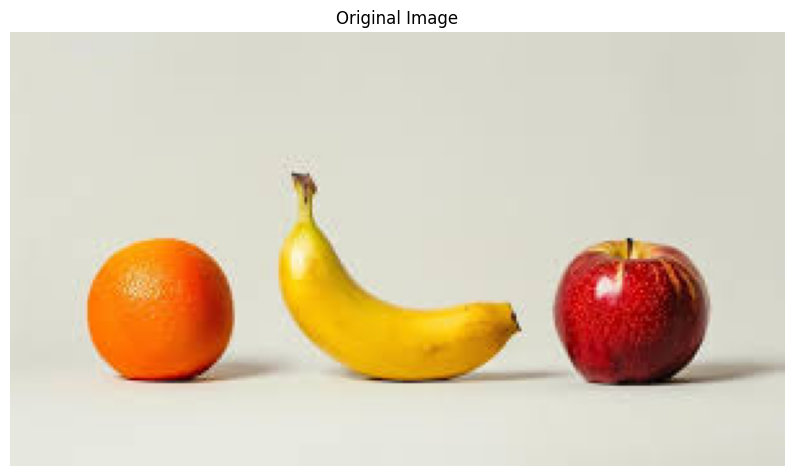


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 8474.9ms
Speed: 6.1ms preprocess, 8474.9ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


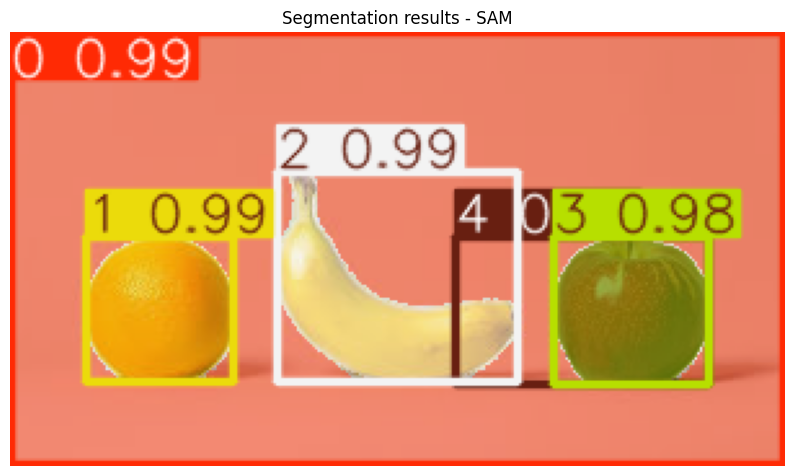

Number of objects detected by SAM: 4


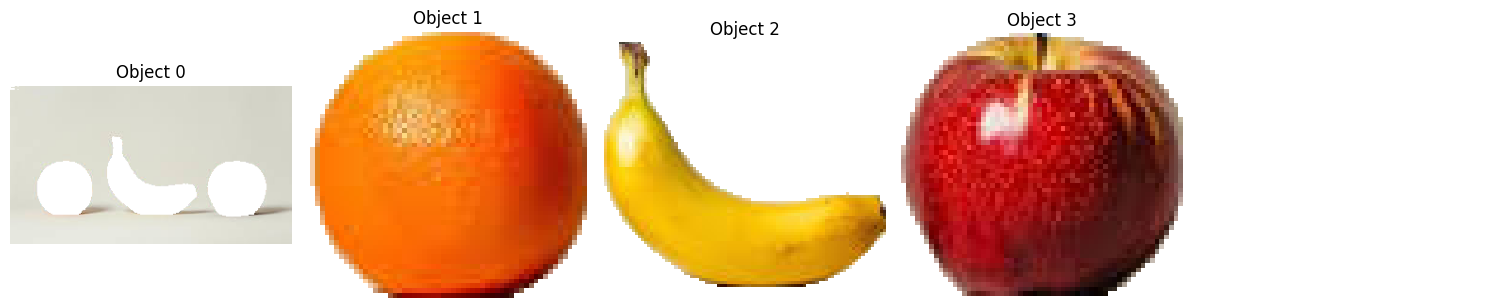

  model  object_id                 bbox        filename
0   sam          0     [0, 0, 299, 167]  samobject0.png
1   sam          1    [29, 80, 86, 135]  samobject1.png
2   sam          2  [104, 55, 196, 135]  samobject2.png
3   sam          3  [210, 80, 270, 136]  samobject3.png


In [14]:
import torch
from ultralytics import SAM
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from PIL import Image
from sklearn.metrics import jaccard_score
from torchvision.models import resnet50
from torchvision.transforms import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#Calculating the Intersection over Union (IoU) between two binary masks
def iou(mask1, mask2):
    return jaccard_score(mask1.flatten(), mask2.flatten())


#adding a white background for every individual object
def place_on_white_background(image):
    white_bg = np.ones_like(image) * 255
    mask = np.any(image != [0, 0, 0], axis=-1)
    white_bg[mask] = image[mask]
    return white_bg

#processing sam results and extracting individual objects
def process_sam_results(results, sam_model_name, iou_threshold=0.5, min_object_size=50):
    original_image = results[0].orig_img
    masks = results[0].masks.data.cpu().numpy()
    
    unique_objects = []
    for i, mask in enumerate(masks):
        is_unique = True
        for existing_obj in unique_objects:
            if iou(mask, existing_obj['mask']) > iou_threshold:
                is_unique = False
                break
        
        if is_unique:
            object_mask = mask.astype(bool)
            object_image = np.zeros_like(original_image)
            object_image[object_mask] = original_image[object_mask]
            
            # Get bounding box
            y, x = np.where(object_mask)
            y1, y2, x1, x2 = y.min(), y.max(), x.min(), x.max()
            
            cropped_object = object_image[y1:y2, x1:x2]
            
            # Skip extremely small objects
            if cropped_object.shape[0] < min_object_size or cropped_object.shape[1] < min_object_size:
                continue
            
            object_on_white = place_on_white_background(cropped_object)
            
            object_filename = f"{sam_model_name}object{len(unique_objects)}.png"
            cv2.imwrite(object_filename, cv2.cvtColor(object_on_white, cv2.COLOR_RGB2BGR))
            
            unique_objects.append({
                'model': sam_model_name,
                'object_id': len(unique_objects),
                'image': Image.fromarray(object_on_white),
                'mask': mask,
                'bbox': [x1, y1, x2, y2],
                'filename': object_filename
            })
    
    return unique_objects

#visualizing the objects
def visualize_objects(objects, cols=5):
    n = len(objects)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.flatten()
    
    for i, obj in enumerate(objects):
        axs[i].imshow(obj['image'])
        axs[i].axis('off')
        axs[i].set_title(f"Object {obj['object_id']}")
    
    for i in range(n, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    
#determining whether the image contains object
def is_object(image, model):
    # Preprocess the image
    image = F.to_tensor(image)
    image = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    image = image.unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(image)
    
    # Check if the top predicted class is not background (assuming background is class 0)
    _, predicted = output.max(1)
    return predicted.item() != 0

# Loading SAM base model
sam_model = SAM("sam2_b.pt").to(device)

# Loading image
img_path = "/kaggle/input/testing-model-of-mas/Imashe.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Displaying original image
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Processing with SAM model
results = sam_model(img)

# Displaying segmentation results
plt.figure(figsize=(10, 10))
plt.imshow(results[0].plot())
plt.title("Segmentation results - SAM")
plt.axis('off')
plt.show()


objects = process_sam_results(results, "sam")

print(f"Number of objects detected by SAM: {len(objects)}")

# Visualize objects from SAM
visualize_objects(objects)


# Creating DataFrame
df = pd.DataFrame([{k: v for k, v in obj.items() if k not in ['mask', 'image']} for obj in objects])

# Displaying DataFrame
print(df)

# Saving DataFrame to CSV
df.to_csv('segmented_objects.csv', index=False)

# USING SAM versions Small,Base and Large and visualizing the results

In [15]:
import torch,gc
torch.cuda.empty_cache()
gc.collect()

21894


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 6571.5ms
Speed: 4.5ms preprocess, 6571.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


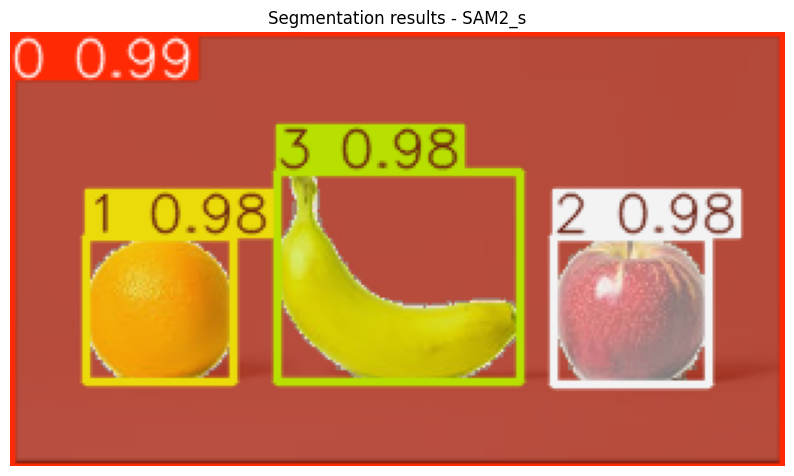

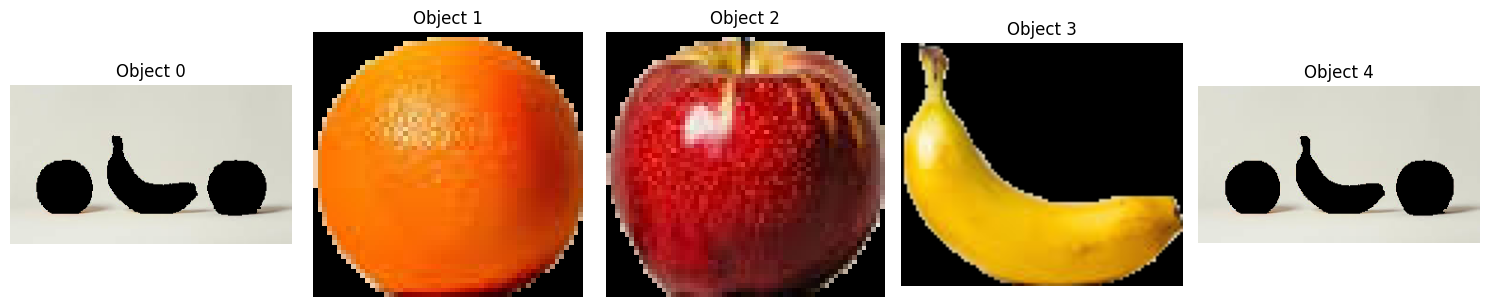

    model  object_id   x1  y1   x2   y2             filename
0  sam2_s          0    0   0  299  168  sam2_s_object_0.png
1  sam2_s          1   29  79   86  135  sam2_s_object_1.png
2  sam2_s          2  210  79  270  136  sam2_s_object_2.png
3  sam2_s          3  103  54  197  135  sam2_s_object_3.png
4  sam2_s          4    0   0  299  167  sam2_s_object_4.png


In [16]:
from ultralytics import SAM
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import os
#processing sam results and extracting individual objects
def process_sam_results(results, model_name):
    original_image = results[0].orig_img
    masks = results[0].masks.data.cpu().numpy()
    boxes = results[0].boxes.data.cpu().numpy()
    
    objects = []
    for i, (mask, box) in enumerate(zip(masks, boxes)):
        object_mask = mask.astype(bool)
        object_image = np.zeros_like(original_image)
        object_image[object_mask] = original_image[object_mask]
        
        x1, y1, x2, y2 = map(int, box[:4])
        cropped_object = object_image[y1:y2, x1:x2]
        
        object_filename = f"{model_name}_object_{i}.png"
        cv2.imwrite(object_filename, cv2.cvtColor(cropped_object, cv2.COLOR_RGB2BGR))
        
        objects.append({
            'model': model_name,
            'object_id': i,
            'image': Image.fromarray(cropped_object),
            'x1': x1,
            'y1': y1,
            'x2': x2,
            'y2': y2,
            'filename': object_filename
        })
    
    return objects
#visualizing the results
def visualize_objects(objects, cols=5):
    n = len(objects)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.flatten()
    
    for i, obj in enumerate(objects):
        axs[i].imshow(obj['image'])
        axs[i].axis('off')
        axs[i].set_title(f"Object {obj['object_id']}")
    
    for i in range(n, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Loading the image
img_path = "/kaggle/input/testing-model-of-mas/Imashe.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Processing with SAM2_s model
sam_model_s = SAM("sam2_s.pt")
results_s = sam_model_s(img)

# Displaying segmentation results
plt.figure(figsize=(10, 10))
plt.imshow(results_s[0].plot())
plt.title("Segmentation results - SAM2_s")
plt.axis('off')
plt.show()

# Process and visualize objects
objects_s = process_sam_results(results_s, "sam2_s")
visualize_objects(objects_s)

# Creating DataFrame
df_s = pd.DataFrame(objects_s)
df_s = df_s.drop('image', axis=1)  # Remove image column as it's not serializable

# Displaying DataFrame
print(df_s)

# Saving DataFrame to CSV
df_s.to_csv('segmented_objects_sam2_s.csv', index=False)


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 8683.3ms
Speed: 4.9ms preprocess, 8683.3ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


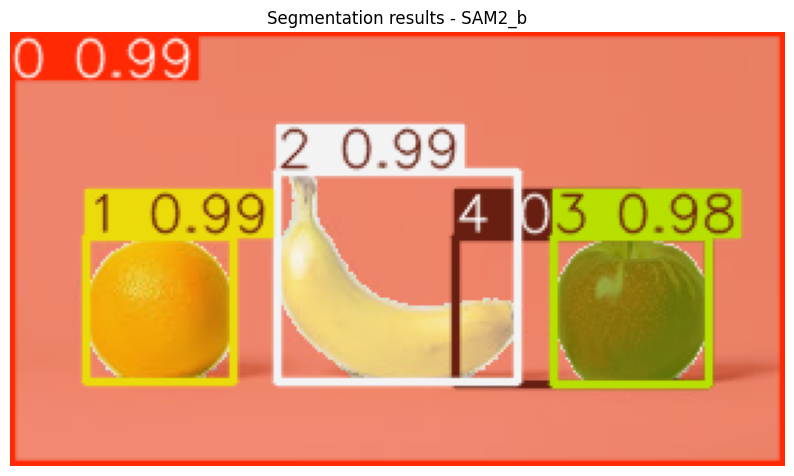

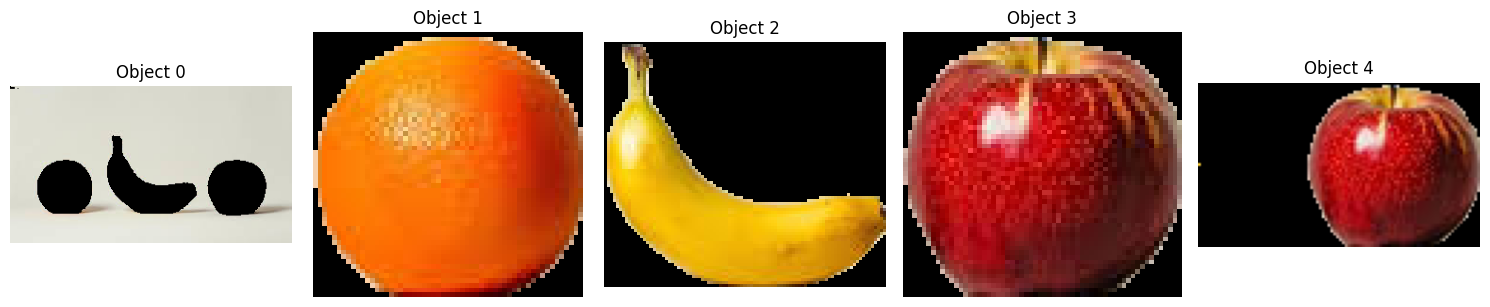

    model  object_id   x1  y1   x2   y2             filename
0  sam2_b          0    0   0  299  167  sam2_b_object_0.png
1  sam2_b          1   29  79   86  135  sam2_b_object_1.png
2  sam2_b          2  103  54  196  135  sam2_b_object_2.png
3  sam2_b          3  210  79  270  136  sam2_b_object_3.png
4  sam2_b          4  172  79  270  136  sam2_b_object_4.png


In [17]:
# Processing with SAM2_b model
sam_model_b = SAM("sam2_b.pt")
results_b = sam_model_b(img)

# Displaying segmentation results
plt.figure(figsize=(10, 10))
plt.imshow(results_b[0].plot())
plt.title("Segmentation results - SAM2_b")
plt.axis('off')
plt.show()

# Process and visualize objects
objects_b = process_sam_results(results_b, "sam2_b")
visualize_objects(objects_b)

# Creating DataFrame
df_b = pd.DataFrame(objects_b)
df_b = df_b.drop('image', axis=1)  # Remove image column as it's not serializable

# Displaying DataFrame
print(df_b)

# Saving DataFrame to CSV
df_b.to_csv('segmented_objects_sam2_b.csv', index=False)


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 14900.5ms
Speed: 4.5ms preprocess, 14900.5ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


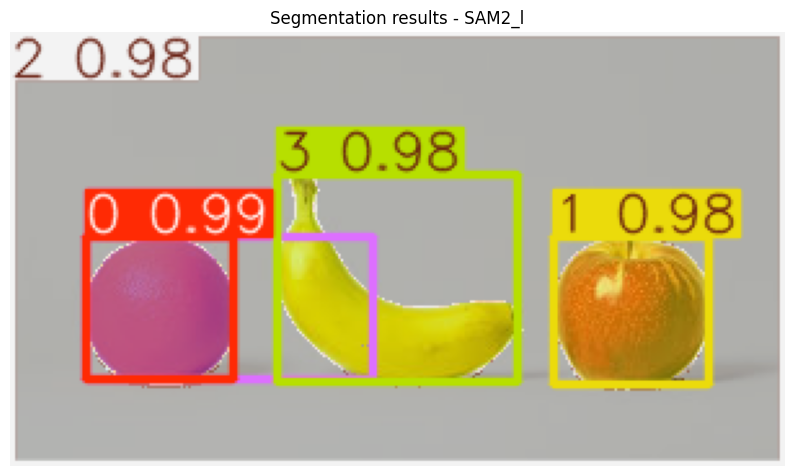

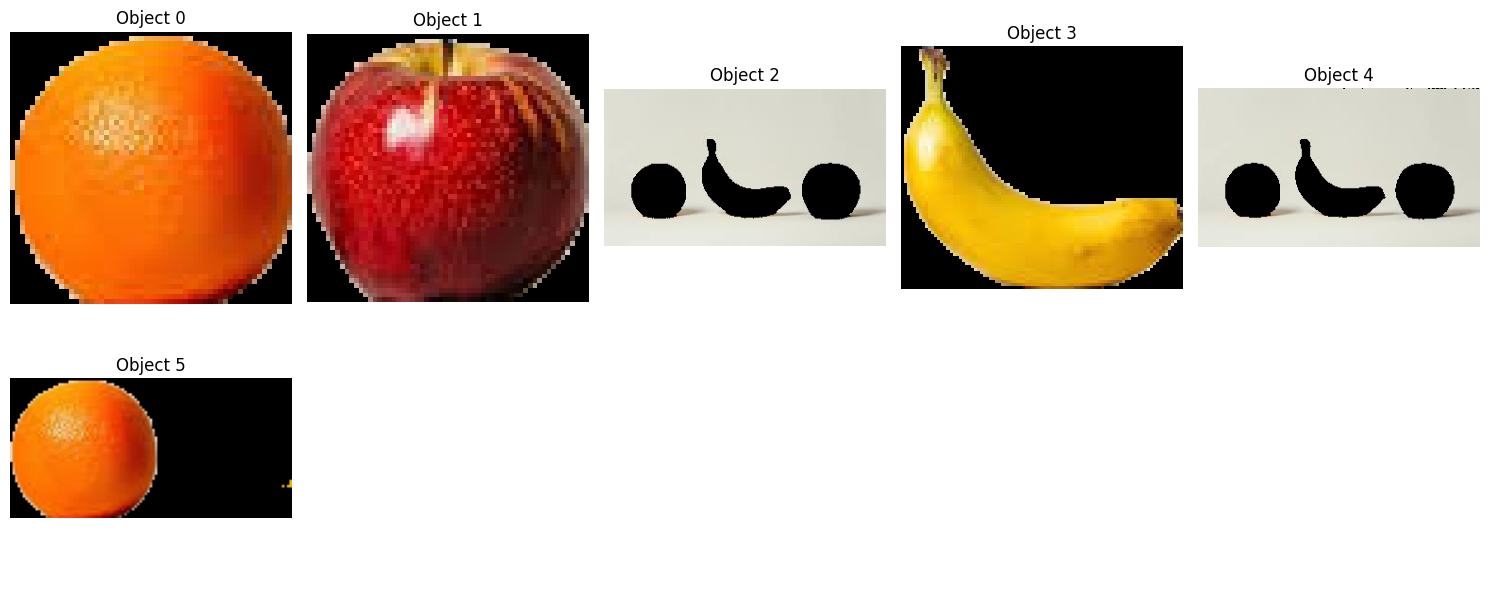

    model  object_id   x1  y1   x2   y2             filename
0  sam2_l          0   29  79   86  134  sam2_l_object_0.png
1  sam2_l          1  210  79  270  136  sam2_l_object_1.png
2  sam2_l          2    0   0  299  167  sam2_l_object_2.png
3  sam2_l          3  103  55  196  135  sam2_l_object_3.png
4  sam2_l          4    0   0  299  168  sam2_l_object_4.png
5  sam2_l          5   29  79  140  134  sam2_l_object_5.png


In [18]:
# Processing with SAM2_l model
sam_model_l = SAM("sam2_l.pt")
results_l = sam_model_l(img)

# Displaying segmentation results
plt.figure(figsize=(10, 10))
plt.imshow(results_l[0].plot())
plt.title("Segmentation results - SAM2_l")
plt.axis('off')
plt.show()

# Process and visualize objects
objects_l = process_sam_results(results_l, "sam2_l")
visualize_objects(objects_l)

# Creating DataFrame
df_l = pd.DataFrame(objects_l)
df_l = df_l.drop('image', axis=1)  # Remove image column as it's not serializable

# Displaying DataFrame
print(df_l)

# Saving DataFrame to CSV
df_l.to_csv('segmented_objects_sam2_l.csv', index=False)

# IMPLEMENTAION OF SAM (INITIAL)

In [ ]:
import torch,gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
#the code without is_object() ie without filtering of objects
from ultralytics import SAM
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import jaccard_score

def iou(mask1, mask2):
    return jaccard_score(mask1.flatten(), mask2.flatten())

def process_sam_results(results, model_name, iou_threshold=0.8):
    original_image = results[0].orig_img
    masks = results[0].masks.data.cpu().numpy()
    boxes = results[0].boxes.data.cpu().numpy()
    
    unique_objects = []
    for i, (mask, box) in enumerate(zip(masks, boxes)):
        is_unique = True
        for existing_obj in unique_objects:
            if iou(mask, existing_obj['mask']) > iou_threshold:
                is_unique = False
                break
        
        if is_unique:
            object_mask = mask.astype(bool)
            object_image = np.zeros_like(original_image)
            object_image[object_mask] = original_image[object_mask]
            
            x1, y1, x2, y2 = map(int, box[:4])
            cropped_object = object_image[y1:y2, x1:x2]
            
            object_filename = f"{model_name}_object_{len(unique_objects)}.png"
            cv2.imwrite(object_filename, cv2.cvtColor(cropped_object, cv2.COLOR_RGB2BGR))
            
            unique_objects.append({
                'model': model_name,
                'object_id': len(unique_objects),
                'image': Image.fromarray(cropped_object),
                'mask': mask,
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'filename': object_filename
            })
    
    return unique_objects

def visualize_objects(objects, cols=5):
    n = len(objects)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = axs.flatten()
    
    for i, obj in enumerate(objects):
        axs[i].imshow(obj['image'])
        axs[i].axis('off')
        axs[i].set_title(f"Object {obj['object_id']}")
    
    for i in range(n, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load image
img_path = "/kaggle/input/testing-model-of-mas/three-apples-arranged-row-white-s-natural-snack-fresh-fruit-apple-image_1295756-210926.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)



# Process with SAM2_b model
sam_model_b = SAM("sam2_b.pt")
results_b = sam_model_b(img)

# Display segmentation results
plt.figure(figsize=(10, 10))
plt.imshow(results_b[0].plot())
plt.title("Segmentation results - SAM2_b")
plt.axis('off')
plt.show()

# Process and visualize objects
objects_b = process_sam_results(results_b, "sam2_b")
visualize_objects(objects_b)

# Create DataFrame
df_b = pd.DataFrame([{k: v for k, v in obj.items() if k != 'mask' and k != 'image'} for obj in objects_b])

# Display DataFrame
print(df_b)

# Save DataFrame to CSV
df_b.to_csv('segmented_objects_sam2_b.csv', index=False)

# Nothing Just a try of images

In [ ]:
'''
Down.webp - sam2_l.pt is the winner
f.jpg - sam_b and sam_l are same {iou threshold is best and works for above 0.8 also 0.9 and also 0.7}
/kaggle/input/testing-model-of-mas/three-apples-arranged-row-white-s-natural-snack-fresh-fruit-apple-image_1295756-210926.jpg  {sam_s and b and l are same and perfect with threshold 0.8}
/kaggle/input/testing-model-of-mas/top-view-fresh-pears-with-persimmons-apples-white-table-fruit-fresh-mellow-ripe_140725-127043.jpg  {sam s and b and l are same and perfect}
/kaggle/input/testing-model-of-mas/top-view-grapefruit-with-oranges-pink-background_141793-51393.jpg {sam s and b and l all are perfect}
/kaggle/input/testing-model-of-mas/top-view-limes-with-oranges-basket-turquoise-background_141793-51702.jpg {sam s and sam b and sam l all are perfect but sam s and sam b are to be considered since we need only the objects not the complete each and every tiny thing in the image}
/kaggle/input/testing-model-of-mas/top-view-pattern-fruits-as-peach-apricot-pear-set-round-shape-wooden-background-with-copy-space.jpg

'''

# COMPLETE

In [ ]:
# /kaggle/input/testing-model-of-mas/gowtham-agm-KQOE-ZnM-Vg-unsplash.jpg

# /kaggle/input/testing-model-of-mas/top-view-grapefruit-with-oranges-pink-background_141793-51393.jpg

# **Also tried YOLO segmentation model**

100%|██████████| 5.90M/5.90M [00:00<00:00, 70.4MB/s]



0: 448x640 3 oranges, 57.2ms
Speed: 2.2ms preprocess, 57.2ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


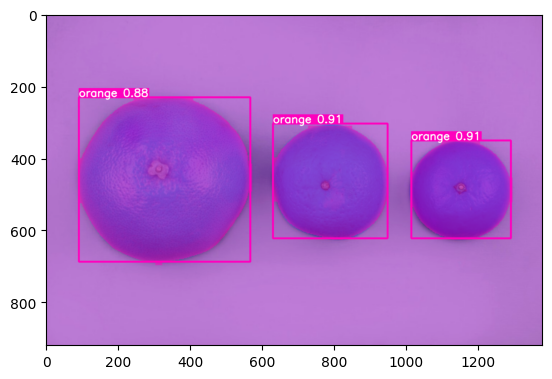

In [20]:
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Load your custom-trained YOLO model (uploaded to Kaggle)
model = YOLO('yolo11n-seg.pt')  # Path to your .pt file

# Load the image you want to run inference on
img = cv2.imread("/kaggle/input/testing-model-of-mas/top-view-grapefruit-with-oranges-pink-background_141793-51393.jpg")
# Run inference on the image
results = model(img)

# Display the results with bounding boxes and labels
plt.imshow(results[0].plot())
plt.show()

# BOUNDING BOXES FOR SEGMENTS IS DONE BY USING FEQE


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 8392.6ms
Speed: 6.4ms preprocess, 8392.6ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


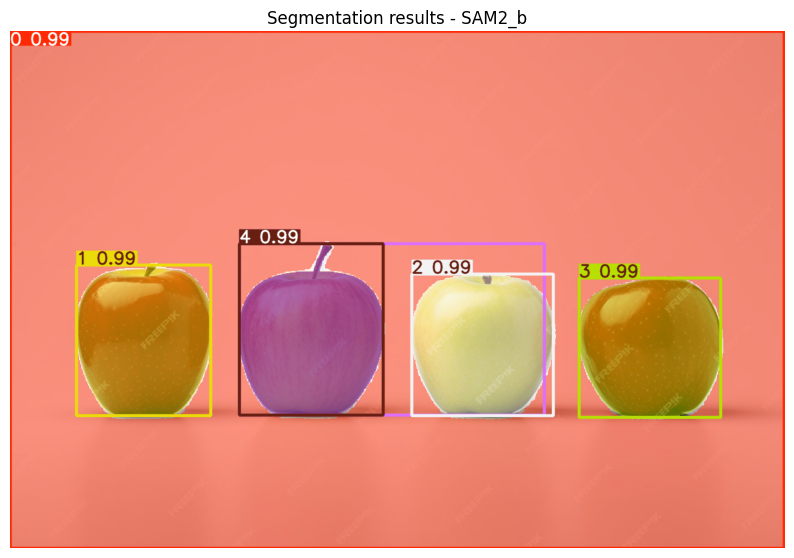

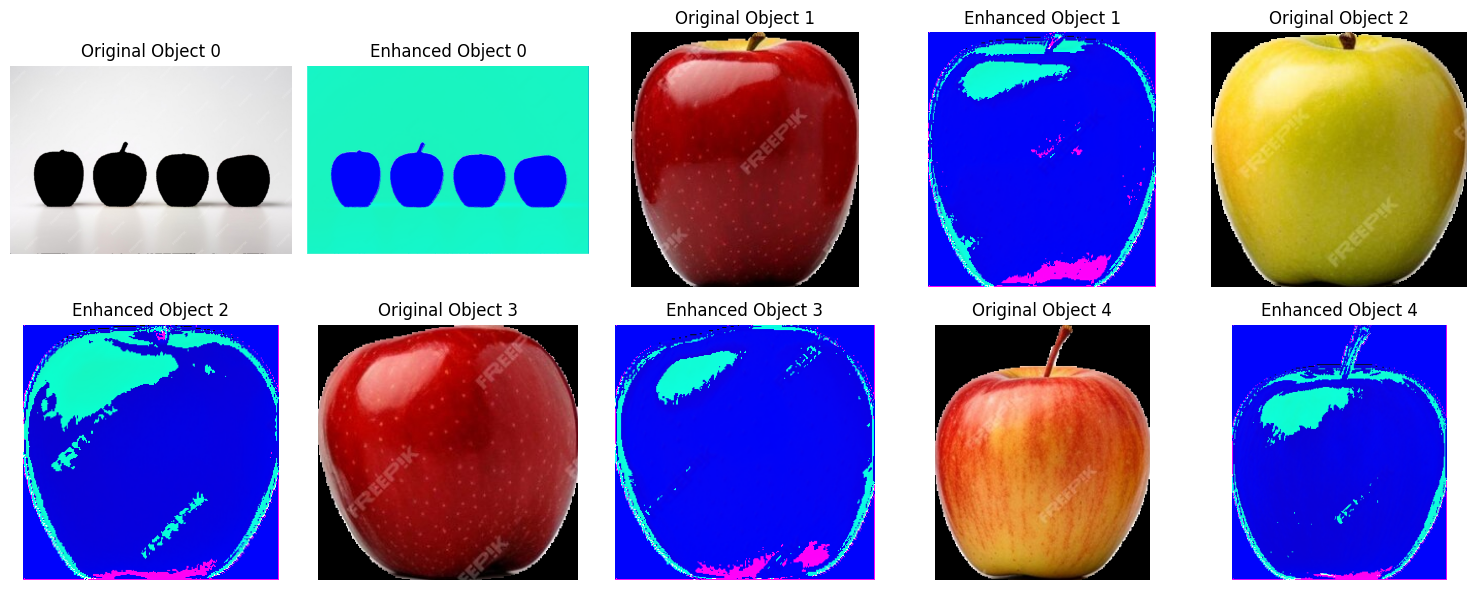

    model  object_id    x1   y1    x2   y2             original_filename  \
0  sam2_b          0     0    0  1378  920  sam2_b_object_0_original.png   
1  sam2_b          1   118  416   357  684  sam2_b_object_1_original.png   
2  sam2_b          2   715  432   967  684  sam2_b_object_2_original.png   
3  sam2_b          3  1013  439  1265  687  sam2_b_object_3_original.png   
4  sam2_b          4   408  378   664  683  sam2_b_object_4_original.png   

              enhanced_filename  
0  sam2_b_object_0_enhanced.png  
1  sam2_b_object_1_enhanced.png  
2  sam2_b_object_2_enhanced.png  
3  sam2_b_object_3_enhanced.png  
4  sam2_b_object_4_enhanced.png  


In [21]:

from ultralytics import SAM
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import os
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.nn.functional as F

def iou(mask1, mask2):
    return jaccard_score(mask1.flatten(), mask2.flatten())

class FEQE(nn.Module):
    def __init__(self, num_channels=3):
        super(FEQE, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, num_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        return x

def enhance_image(image, model):
    image_tensor = torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0) / 255.0
    with torch.no_grad():
        enhanced_tensor = model(image_tensor)
    enhanced_image = (enhanced_tensor.squeeze().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    return enhanced_image

def process_sam_results(results, model_name, iou_threshold=0.8, feqe_model=None):
    original_image = results[0].orig_img
    masks = results[0].masks.data.cpu().numpy()
    boxes = results[0].boxes.data.cpu().numpy()
    
    unique_objects = []
    for i, (mask, box) in enumerate(zip(masks, boxes)):
        is_unique = True
        for existing_obj in unique_objects:
            if iou(mask, existing_obj['mask']) > iou_threshold:
                is_unique = False
                break
        
        if is_unique:
            object_mask = mask.astype(bool)
            object_image = np.zeros_like(original_image)
            object_image[object_mask] = original_image[object_mask]
            
            x1, y1, x2, y2 = map(int, box[:4])
            cropped_object = object_image[y1:y2, x1:x2]
            
            # Enhance the image using FEQE
            enhanced_object = enhance_image(cropped_object, feqe_model)
            
            # Save original and enhanced images
            original_filename = f"{model_name}_object_{len(unique_objects)}_original.png"
            enhanced_filename = f"{model_name}_object_{len(unique_objects)}_enhanced.png"
            cv2.imwrite(original_filename, cv2.cvtColor(cropped_object, cv2.COLOR_RGB2BGR))
            cv2.imwrite(enhanced_filename, cv2.cvtColor(enhanced_object, cv2.COLOR_RGB2BGR))
            
            unique_objects.append({
                'model': model_name,
                'object_id': len(unique_objects),
                'original_image': Image.fromarray(cropped_object),
                'enhanced_image': Image.fromarray(enhanced_object),
                'mask': mask,
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'original_filename': original_filename,
                'enhanced_filename': enhanced_filename
            })
    
    return unique_objects

def visualize_objects(objects, cols=5):
    n = len(objects)
    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows * 2, cols, figsize=(cols*3, rows*6))
    axs = axs.flatten()
    
    for i, obj in enumerate(objects):
        axs[i*2].imshow(obj['original_image'])
        axs[i*2].axis('off')
        axs[i*2].set_title(f"Original Object {obj['object_id']}")
        
        axs[i*2+1].imshow(obj['enhanced_image'])
        axs[i*2+1].axis('off')
        axs[i*2+1].set_title(f"Enhanced Object {obj['object_id']}")
    
    for i in range(n*2, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Load image
img_path = "/kaggle/input/testing-model-of-mas/three-apples-arranged-row-white-s-natural-snack-fresh-fruit-apple-image_1295756-210926.jpg"
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Initialize FEQE model
feqe_model = FEQE()
feqe_model.eval()

# Process with SAM2_b model
sam_model_b = SAM("sam2_b.pt")
results_b = sam_model_b(img)

# Display segmentation results
plt.figure(figsize=(10, 10))
plt.imshow(results_b[0].plot())
plt.title("Segmentation results - SAM2_b")
plt.axis('off')
plt.show()

# Process and visualize objects
objects_b = process_sam_results(results_b, "sam2_b", feqe_model=feqe_model)
visualize_objects(objects_b)

# Create DataFrame
df_b = pd.DataFrame([{k: v for k, v in obj.items() if k not in ['mask', 'original_image', 'enhanced_image']} for obj in objects_b])

# Display DataFrame
print(df_b)

# Save DataFrame to CSV
df_b.to_csv('segmented_objects_sam2_b.csv', index=False)